# Retea convolutionala de detectie a imaginilor bazata pe celule

Aceasta retea, in loc sa aiba ca date de iesire un singur "neuron" care sa aibă valori între 0 și 1, va suprapune o retea rectangulară de astfel de "neuroni" care va incerca detectia unor fragmente din fețe, în funcție de poziționarea acestora în imagine. Acest notebook prezintă partea de configurare a modelului si antrenarea rețelei neuronale.

Datorită acestui mod de antrenament care se face doar pe fragmente de imagini, nu este nevoie de imagini negative. In imaginile folosite la antrenament sunt foarte multe celule care NU conțin fețe iar antrenamentul se face practic prin divizarea unei imagini intr-o matrice de sub-imagini, unele pozitive si altele negative.

In [1]:
import google.colab
google.colab.drive.mount('/content/gdrive/', force_remount=True)
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.ndimage import grey_dilation
from PIL import Image, ImageDraw
import random
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from google.colab import files
from IPython.display import display
import matplotlib.patches as patches
import json

Mounted at /content/gdrive/


In [2]:
data_dir = '/content/gdrive/MyDrive/Facultate Informatica/Profesor/2024 - 2025/Sisteme expert si metode biometrice in securitatea informatiei/Curs/ColabMount/DATA/train_face_large_dataset'
model_dir = '/content/gdrive/MyDrive/Facultate Informatica/Profesor/2024 - 2025/Sisteme expert si metode biometrice in securitatea informatiei/Curs/ColabMount/Models/Face/GridNetwork'

Verificăm dacă există directoarele cu date

In [5]:
images_dir = os.path.join(data_dir, 'images')
labels_dir = os.path.join(data_dir, 'labels')

In [3]:
if os.path.isdir(data_dir):
  print("Data directory exists")
else:
  print("Data directory does not exist")
if os.path.isdir(model_dir):
  print("Model directory exists")
else:
  print("Model directory does not exist")

Data directory exists
Model directory exists


## Inspecția setului de date

Următoarea celulă citește aleator 10 imagini din setul de date și afișează aceste imagini împreună cu casetele de delimitare a fețelor. Procesul de antrenament trebuie să convertească aceste date într-un format care să se potrivească cu modelul nostru.

In [6]:
image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg') or f.endswith('.jpeg')]
random.shuffle(image_files)
image_files = image_files[:10]  # Pick 10 random images

# Prepare to plot
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

# Process and plot each image
for idx, img_file in enumerate(image_files):
    # Load image
    img_path = os.path.join(images_dir, img_file)
    img = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(img)

    # Load corresponding label
    label_file = os.path.splitext(img_file)[0] + '.txt'
    label_path = os.path.join(labels_dir, label_file)

    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                if len(parts) == 5:
                    _, x_center, y_center, width, height = map(float, parts)

                    # Denormalize coordinates
                    img_w, img_h = img.size
                    x_center *= img_w
                    y_center *= img_h
                    width *= img_w
                    height *= img_h

                    # Calculate box corners
                    x0 = x_center - width / 2
                    y0 = y_center - height / 2
                    x1 = x_center + width / 2
                    y1 = y_center + height / 2

                    draw.rectangle([x0, y0, x1, y1], outline="red", width=4)

    axes[idx].imshow(img)
    axes[idx].set_title(img_file)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Verificăm care este dispozitivul pe care vom face calculele

In [7]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Funcția de transformare conține modificările care vor fi aplicate tuturor imaginilor care trec prin model.

In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

## Implementarea clasei de tip Dataset

Datasetul trebuie să convertească datele disponibile (această situație se întâlnește frecvent) din formatul in care sunt specificate casetele din directorul "labels" în formatul așteptat de modelul nostru.

Un exemplu de format:

```
1 0.6533203125 0.11834016393442623 0.068359375 0.08913934426229508
1 0.25927734375 0.10655737704918032 0.0732421875 0.09836065573770492
1 0.03076171875 0.22079918032786885 0.0615234375 0.09938524590163934
```

prima coloana reprezinta categoria din care face parte obiectul din caseta descrisă pe acea linie. Pentru că modelul antrenat este exclusiv pentru detecția fețelor, toate valorile acestor coloane, peste tot, vor fi 1.

Următoarele 4 coloane sunt numere flotante, între 0 și 1, fiecare dintre ele reprezentând următoarele: coordonata x a centrului casetei, coordonata y a centrului casetei, lățimea casetei (dimensiunea acesteia pe axa x), înălțimea acesteia (dimensiunea acesteia pe axa y).


In [9]:
class GridDataset(Dataset):
    def __init__(self, img_dir, label_dir, grid_size=7, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.grid_size = grid_size
        self.transform = transform
        self.img_names = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        label_path = os.path.join(self.label_dir, img_name.replace('.jpg', '.txt'))

        # Load the image
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)

        # Initialize grid
        grid = np.zeros((self.grid_size, self.grid_size))

        # Parse ground truth label file
        with open(label_path, 'r') as f:
            for line in f.readlines():
                label_data = line.strip().split()
                class_id, cx, cy, w, h = map(float, label_data)

                cx_cell = int(cx * self.grid_size)
                cy_cell = int(cy * self.grid_size)

                # Convert box dimensions to grid cells
                half_w = int((w * self.grid_size) / 2)
                half_h = int((h * self.grid_size) / 2)

                # Find the bounding box grid cells
                for i in range(max(0, cx_cell - half_w), min(self.grid_size, cx_cell + half_w + 1)):
                    for j in range(max(0, cy_cell - half_h), min(self.grid_size, cy_cell + half_h + 1)):
                        grid[i, j] = 1  # Set the cell as containing the object

        # Convert grid to tensor
        grid = torch.tensor(grid, dtype=torch.float32)

        return img, grid

    """
    Metoda display_samples afiseaza cateva imagini impreuna cu gridul suprapus peste acestea.
    """

    def display_samples(self, num_samples=3):
      indices = random.sample(range(len(self)), num_samples)
      fig, axs = plt.subplots(1, num_samples, figsize=(6 * num_samples, 6))

      if num_samples == 1:
          axs = [axs]

      for ax, idx in zip(axs, indices):
          img, grid = self[idx]

          # Convert tensor to numpy array if necessary
          if isinstance(img, torch.Tensor):
              img = img.permute(1, 2, 0).cpu().numpy()  # CHW to HWC

          img_h, img_w = img.shape[:2]
          cell_w = img_w / self.grid_size
          cell_h = img_h / self.grid_size

          ax.imshow(img)
          ax.set_title(f"Sample #{idx}")
          ax.axis('off')

          # Draw grid and red rectangles where grid == 1
          for row in range(self.grid_size):      # Y-axis (rows)
              for col in range(self.grid_size):  # X-axis (columns)
                  x = col * cell_w
                  y = row * cell_h

                  # Draw grid
                  ax.add_patch(patches.Rectangle(
                      (x, y), cell_w, cell_h,
                      linewidth=1, edgecolor='gray', facecolor='none'))

                  # Highlight positive grid cells
                  if grid[row, col] == 1:
                      ax.add_patch(patches.Rectangle(
                          (y, x), cell_w, cell_h,
                          linewidth=2, edgecolor='red', facecolor='none'))

      plt.tight_layout()
      plt.show()

    def print_statistics(self):
        total_samples = len(self)
        total_gt_boxes = 0
        total_cells = total_samples * self.grid_size * self.grid_size
        total_face_cells = 0

        for img_name in self.img_names:
            label_path = os.path.join(self.label_dir, img_name.replace('.jpg', '.txt'))

            # Count ground truth boxes
            with open(label_path, 'r') as f:
                lines = f.readlines()
                total_gt_boxes += len(lines)

                # Reconstruct the grid for counting face cells
                grid = np.zeros((self.grid_size, self.grid_size))
                for line in lines:
                    _, cx, cy, w, h = map(float, line.strip().split())
                    cx_cell = int(cx * self.grid_size)
                    cy_cell = int(cy * self.grid_size)
                    half_w = int((w * self.grid_size) / 2)
                    half_h = int((h * self.grid_size) / 2)

                    for i in range(max(0, cx_cell - half_w), min(self.grid_size, cx_cell + half_w + 1)):
                        for j in range(max(0, cy_cell - half_h), min(self.grid_size, cy_cell + half_h + 1)):
                            grid[i, j] = 1

                total_face_cells += np.sum(grid)

        total_no_face_cells = total_cells - total_face_cells
        percent_face_cells = (total_face_cells / total_cells) * 100

        print(f"Number of samples: {total_samples}")
        print(f"Total ground truth boxes: {total_gt_boxes}")
        print(f"Total grid cells: {total_cells}")
        print(f"Cells with faces: {int(total_face_cells)}")
        print(f"Cells with no faces: {int(total_no_face_cells)}")
        print(f"Percent of cells with faces: {percent_face_cells:.4f}%")


In [15]:
class GridSimpleCNNModel(nn.Module):
    def __init__(self, griddim=7, num_classes=1, image_size = 224):
        super(GridSimpleCNNModel, self).__init__()
        self.griddim = griddim
        self.num_classes = num_classes
        self.image_size = image_size

        # Define the convolutional layers in a Sequential block
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3), nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (64, 56, 56)
            nn.Conv2d(64, 192, kernel_size=3, padding=1), nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (192, 28, 28)
            nn.Conv2d(192, 256, kernel_size=3, padding=1), nn.LeakyReLU(0.1),  # Output: (256, 28, 28)
            nn.Conv2d(256, 512, kernel_size=3, padding=1), nn.LeakyReLU(0.1),  # Output: (512, 28, 28)
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: (512, 14, 14)
        )

        # Calculate the output size after the convolutional layers
        self.conv_output_size = self._get_conv_output_size()

        # Define the fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.conv_output_size, 4096),  # Fully connected layer after conv layers
            nn.ReLU(),
            nn.Linear(4096, self.griddim ** 2),  # Output grid cells
            nn.Sigmoid()  # Sigmoid to output values between 0 and 1
        )

    def forward(self, x):
        # Apply the convolutional layers
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        x = x.view(x.size(0), self.griddim, self.griddim)
        return x

    def _get_conv_output_size(self):
            # Create a dummy input tensor to calculate the output size after conv layers
            dummy_input = torch.ones(1, 3, self.image_size, self.image_size)  # Batch size 1, 3 channels, 224x224 image
            x = self.conv_layers(dummy_input)
            return x.numel()  # Return the number of elements in the tensor after conv layers




## Funcția de cost

Funcția de cost este implementata sub forma de clasa. In pytorch, aceasta implementare solicita existenta unei metode numita "forward" care calculează pierderea.

Metoda forward calculează două valori: pierderea celulelor cu fețe și pierderea celulelor fără fețe. Ambele pierderi folosesc Binary Cross-Entropy loss - clasificarea este tot binară. Motivul pentru care separăm cele două termeme este pentru că dorim să penalizăm mai puțin celulele în care fețele nu există. Detecția corectă unei celule în care există o față este mult mai importantă decât detecția corectă a unei celule goale.

Astfel, dorim ca modelul să fie puternic favorabil detecției corecte și modificarea coeficienților acestora în timpul antrenamentului să fie mult mai influențați de detecția corectă.

În plus, statistic vorbind, celulele care conțin fețe sunt mai rare.

Pentru a calcula separat cei doi termeni în deschiderea metodei forward se construiesc două "măști" - doua matrici de dimensiuni identice in care una are True acolo unde există fețe (obj_mask), și celaltă care are True acolo unde nu există detecții (noobj_mask). Cu ajutorul acestor matrici se adună detecțiile pozitive și cele negative în cei doi termeni iar cei doi termeni se vor aduna într-o sumă ponderată cu factorii de influență (lambda_obj=1.0, lambda_noobj=0.5).

In [14]:
class GridLoss(nn.Module):
    def __init__(self, lambda_obj=1.0, lambda_noobj=0.5):
        super(GridLoss, self).__init__()
        self.lambda_obj = lambda_obj
        self.lambda_noobj = lambda_noobj
        self.bce_loss = nn.BCELoss(reduction='none')

    def forward(self, pred, target):
        # Calculate object and non-object cells
        obj_mask = target == 1
        noobj_mask = target == 0

        # Calculate the objectness loss
        obj_loss = self.bce_loss(pred[obj_mask], target[obj_mask])

        # Calculate the non-objectness loss
        noobj_loss = self.bce_loss(pred[noobj_mask], target[noobj_mask])

        # Weighted sum of objectness and non-objectness losses
        obj_loss = obj_loss.sum()
        noobj_loss = noobj_loss.sum()

        total_loss = self.lambda_obj * obj_loss + self.lambda_noobj * noobj_loss
        return total_loss

## Hiperparametrii

Hiperparametrii sunt variabile care influențează structura modelului și a procesului de antrenament;


- **learning_rate** - Rata de învățare controlează cât de repede se actualizează greutățile modelului în timpul antrenării.
- **epochs** - Numărul de epoci - de câte ori trece modelul prin întregul set de date de antrenare.
- **batch_size**: Câte exemple sunt procesate simultan înainte de a actualiza greutățile.
- **grid_size**: Dimensiunea grilei - imaginea este împărțită într-o grilă de NxN celule pentru detecția obiectelor.
- **input resolution**: Rezoluția de intrare - dimensiunea (lățime și înălțime) la care sunt redimensionate imaginile de intrare.
- **lambda_obj**: Ponderea erorii pentru celulele care conțin obiecte - controlează importanța acestora în funcția de pierdere.
- **lambda_noobj**: Ponderea erorii pentru celulele fără obiecte - controlează penalizarea pentru predicții greșite acolo unde nu sunt obiecte.
- **device**: Dispozitivul folosit - „cuda” pentru GPU sau „cpu” pentru procesor, în funcție de disponibilitate.
- **model_name_root**: "cnn_grid_model_224_7"  - Numele de bază al modelului,  folosit pentru salvarea modelelor antrenate.


In [12]:
hyperparameters = {
    "learning_rate": 0.00005,
    "epochs": 100,
    "batch_size": 32,
    "grid_size" : 7,
    "input resolution" : 224,
    "lambda_obj": 1.0,
    "lambda_noobj": 0.5,
    "device": str(DEVICE),
    "model_name_root": "cnn_grid_model_224_7"
}

## Initializarea setului de date si a modelului

In [16]:
dataset = GridDataset(images_dir, labels_dir, grid_size=hyperparameters['grid_size'], transform=transform)
model = GridSimpleCNNModel(griddim=hyperparameters['grid_size'], image_size=224).to(DEVICE)


## Inspectarea datelor

Putem vizualiza câteva imagini pentru a vedea cum se convertesc casetele de detecție la grila.

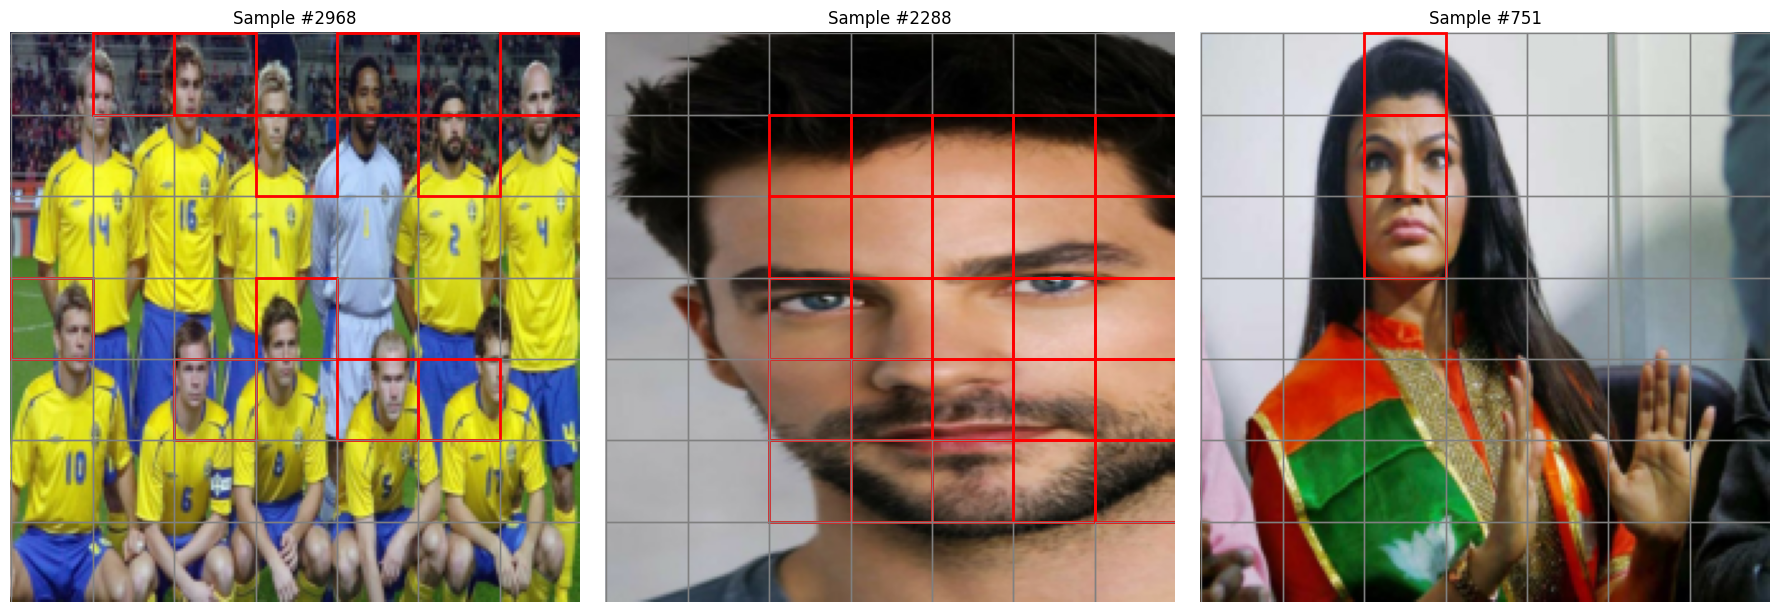

In [21]:
dataset.display_samples()

## Statistici ale setului de date

Statisticile dureaza foarte mult - circa 25 min. Rezultatul este urmatorul:

- **Number of samples**: 4312
- **Total ground truth boxes**: 6972
- **Total grid cells**: 211288
- **Cells with faces**: 16104
- **Cells with no faces**: 195184
- **Percent of cells with faces**: 7.6218%

In [ ]:
dataset.print_statistics()

Number of samples: 4312
Total ground truth boxes: 6972
Total grid cells: 211288
Cells with faces: 16104
Cells with no faces: 195184
Percent of cells with faces: 7.6218%


In [ ]:
dataloader = DataLoader(dataset, batch_size=hyperparameters['batch_size'], shuffle=True)

In [ ]:
loss_fn = GridLoss(lambda_obj=hyperparameters['lambda_obj'], lambda_noobj=hyperparameters['lambda_noobj']).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters['learning_rate'])


## Antrenarea modelului

Antrenarea modelului dureaza destul de mult (cateva ore) cu utilizarea unui runtime cu T4 iar convergenta este lenta. Modelul converge undeva peste 170 de epoci (cu pierderea totala scăzând sub 0.1). Este greu de antrenat până la capăt pe google collaboratory pentru ca acesta întrerupe runtime-ul dupa un timp.  

In [ ]:
for epoch in range(hyperparameters['epochs']):
    model.train()
    total_loss = 0.0
    total_batches = len(dataloader)
    i = 1
    for imgs, labels in dataloader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        # Forward pass
        pred = model(imgs)
        # Compute the loss
        loss = loss_fn(pred, labels)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        print(f"    -> Batch number: {i} Batch loss: {loss} Total loss: {total_loss} total batches: {len(dataloader)}")
        i = i + 1

    print(f"Epoch [{epoch+1}/{hyperparameters['epochs']}], Loss: {total_loss/len(dataloader)}")

    torch.save(model.state_dict(), f"{hyperparameters['model_name_root']}_{epoch+1}.pth")

    -> Batch number: 1 Batch loss: 579.9579467773438 Total loss: 579.9579467773438 total batches: 135
    -> Batch number: 2 Batch loss: 536.4199829101562 Total loss: 1116.3779296875 total batches: 135
    -> Batch number: 3 Batch loss: 472.7648010253906 Total loss: 1589.1427307128906 total batches: 135
    -> Batch number: 4 Batch loss: 415.880126953125 Total loss: 2005.0228576660156 total batches: 135
    -> Batch number: 5 Batch loss: 406.60107421875 Total loss: 2411.6239318847656 total batches: 135
    -> Batch number: 6 Batch loss: 355.45086669921875 Total loss: 2767.0747985839844 total batches: 135
    -> Batch number: 7 Batch loss: 237.22561645507812 Total loss: 3004.3004150390625 total batches: 135
    -> Batch number: 8 Batch loss: 272.6300048828125 Total loss: 3276.930419921875 total batches: 135
    -> Batch number: 9 Batch loss: 238.9012451171875 Total loss: 3515.8316650390625 total batches: 135
    -> Batch number: 10 Batch loss: 249.21298217773438 Total loss: 3765.0446472

## Detaliile procesului de antrenament

Procesul de antrenament (rulat în altă parte) a înregistrat într-un fișier json parcursul procesului.

In [ ]:
def format_fuzzy_time(seconds):
    seconds = int(round(seconds))
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    secs = seconds % 60

    parts = []
    if hours > 0:
        parts.append(f"{hours} {'hour' if hours == 1 else 'hours'}")
    if minutes > 0:
        parts.append(f"{minutes} {'minute' if minutes == 1 else 'minutes'}")
    if secs > 0 or not parts:
        parts.append(f"{secs} {'second' if secs == 1 else 'seconds'}")

    return ' '.join(parts)

In [ ]:
training_json = os.path.join(model_dir, '224', 'GridSimpleCNNModel', 'grid_simple_model_21.json')
print(training_json)

/content/gdrive/MyDrive/Facultate Informatica/Profesor/2024 - 2025/Sisteme expert si metode biometrice in securitatea informatiei/Curs/ColabMount/Models/Face/GridNetwork/224/GridSimpleCNNModel/grid_simple_model_21.json


Total training time up to epoch 193: 3 hours 58 minutes 5 seconds


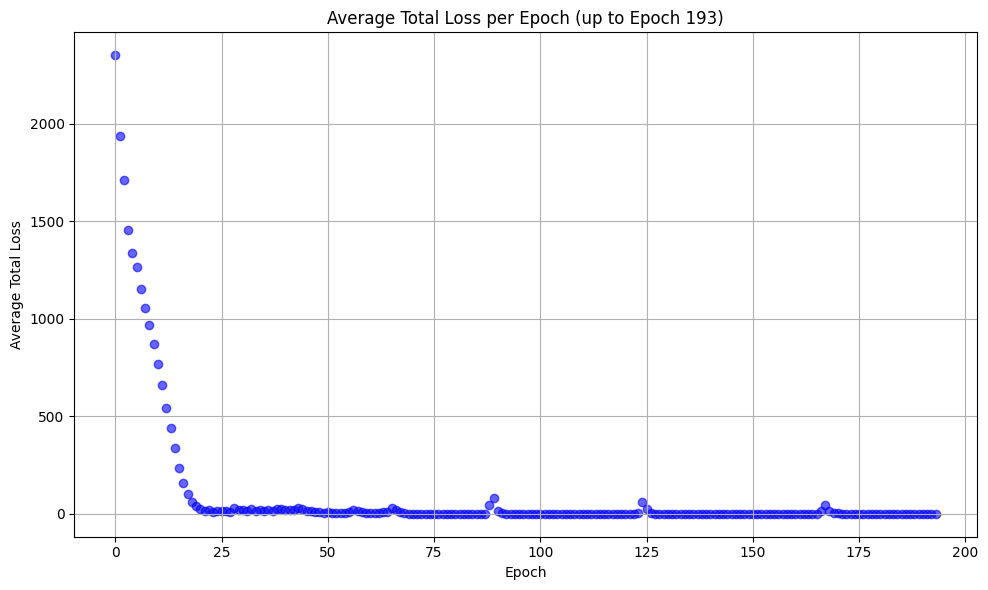

In [ ]:
import json
with open(training_json, "r") as f:
    data = json.load(f)

best_epoch = data["best_model"]["epoch"]

# Filter the epochs up to and including the best one
epochs_data = [e for e in data["epochs"] if e["epoch"] <= best_epoch]

# Calculate total training time
total_time = sum(e["duration"] for e in epochs_data)
print(f"Total training time up to epoch {best_epoch}: {format_fuzzy_time(total_time)}")

# Extract data for plotting
epoch_nums = [e["epoch"] for e in epochs_data]
avg_losses = [e["avg_total_loss"] for e in epochs_data]

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(epoch_nums, avg_losses, color='blue', alpha=0.6)
plt.title(f'Average Total Loss per Epoch (up to Epoch {best_epoch})')
plt.xlabel('Epoch')
plt.ylabel('Average Total Loss')
plt.grid(True)
plt.tight_layout()
plt.show()